<a href="https://colab.research.google.com/github/datasolut/tutorials/blob/master/Supervised_Learning_01_Klassifikation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning 01 - Klassifikation

## Daten einlesen und kennenlernen

Daten stehen zur Verfügung unter https://archive.ics.uci.edu/ml/datasets/online+retail und https://archive.ics.uci.edu/ml/datasets/Online+Retail+II.

In [ ]:
import numpy as np
import pandas as pd

url1 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
url2 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx'

df1 = pd.read_excel(url1)
df2 = pd.read_excel(url2)

#

In [ ]:
print(df1.shape)
print(df2.shape)

(541909, 8)
(525461, 8)


In [ ]:
# Kombiniere Datensätze
df2.columns = df1.columns
df = pd.concat([df1, df2])

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067370 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   InvoiceNo    1067370 non-null  object        
 1   StockCode    1067370 non-null  object        
 2   Description  1062988 non-null  object        
 3   Quantity     1067370 non-null  int64         
 4   InvoiceDate  1067370 non-null  datetime64[ns]
 5   UnitPrice    1067370 non-null  float64       
 6   CustomerID   824363 non-null   float64       
 7   Country      1067370 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB


In [ ]:
# Alle Spaltennamen klein schreiben
df.columns = df.columns.str.lower()

In [ ]:
# Welchen Zeitraum betrachten wir?
df['invoicedate'].describe()

count                 1067370
unique                  47635
top       2010-12-06 16:57:00
freq                     1350
first     2009-12-01 07:45:00
last      2011-12-09 12:50:00
Name: invoicedate, dtype: object

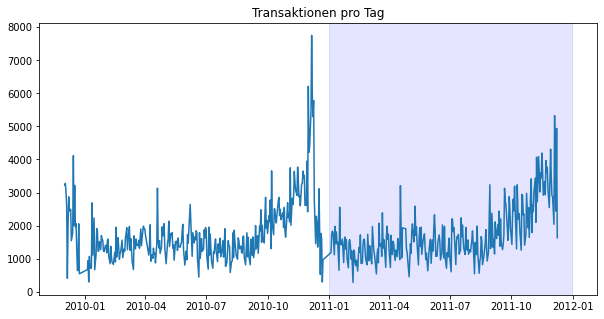

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
df['invoicedate'].dt.date.value_counts().sort_index().plot();
plt.title('Transaktionen pro Tag');
plt.axvspan('2011-01-01','2011-12-31', color='b', alpha=0.1);

## Daten säubern

In [ ]:
# Lösche Dubletten
df = df.drop_duplicates(ignore_index=True)

# Lösche Transaktionen ohne Customer ID
df = df.dropna(subset=['customerid'])
df['customerid'] = df['customerid'].astype(int)

# Lösche stornierte Transaktionen
df['invoiceno'] = df['invoiceno'].astype(str)
df['iscancelled'] = np.where(df['invoiceno'].str.startswith('C'), 1, 0)
df = df.loc[df['iscancelled']==0]
df = df.drop('iscancelled', axis=1)

# Entferne Transaktionen mit unitprice==0
df = df.loc[df['unitprice']>0]

# Entfernen von Transaktionen mit Quantity == 0 oder > 100
df = df.loc[(df["quantity"] > 0)] #& (df["quantity"] <= 100)] 

# Lösche alle Transaktionen mit nichtnumerischen StockCodes
df['stockcode'] = df['stockcode'].astype(str)
df = df.loc[df['stockcode']<='99999'] 


In [ ]:
# Aufbereitung der Rohdaten

df['revenue'] = df['quantity'] * df['unitprice']
df['dayofweek'] = df['invoicedate'].dt.dayofweek
df['month'] = df['invoicedate'].dt.month

df['invoicedate'] = df['invoicedate'].dt.date #normalize()

## Abtrennung Vorhersagezeitraum

In [ ]:

# Trennung des Datensatzes
cutoff_date = pd.to_datetime('2011-01-01').date()
#cutoff_date = datetime.date('2010-01-01')

df_history = df.loc[df['invoicedate'] < cutoff_date]
df_target = df.loc[df['invoicedate'] >= cutoff_date]

print(df_history.shape)
print(df_target.shape)

(410996, 11)
(365581, 11)


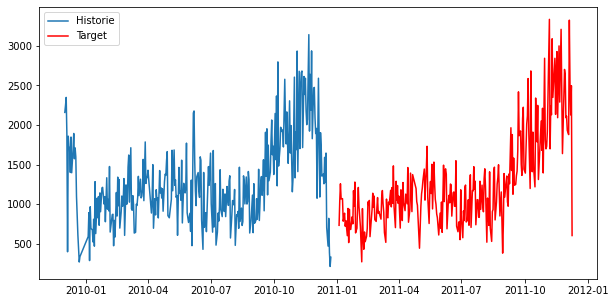

In [ ]:
plt.figure(figsize=(10,5))
df_history['invoicedate'].value_counts().sort_index().plot(label='Historie');
df_target['invoicedate'].value_counts().sort_index().plot(color='r', label='Target');
plt.legend();

## Target-Definition: Was wollen wir vorhersagen?
a) Aktivität: Wird der Kunde in 2011 etwas kaufen? ja/nein? (Klassifikation)  
b) Umsatz: Wieviel Umsatz wird der Kunde in 2011 generieren? (Regression)

In [ ]:

# Definition Kundenbasis mit History
df_customers = pd.DataFrame(df_history['customerid'].unique())
df_customers.columns = ['customerid']

# Labeling: Zunächst der Umsatz pro Kunde
labels = df_target.groupby('customerid')['revenue'].sum().reset_index()
labels.columns = ['customerid', 'rev_target']

# Anschließend das Aktivitäts-Label: Ja/Nein
labels['act_target'] = np.where(labels['rev_target']>0.0, 1, 0)

# Labels mit Kundenbasis verbinden
df_customers = df_customers.merge(labels, on='customerid', how='left')
df_customers.fillna(value=0, inplace=True)


In [ ]:
print(df_customers.shape)
print(df_customers['act_target'].value_counts())

(4315, 3)
1.0    2677
0.0    1638
Name: act_target, dtype: int64


## Feature Engineering

In [ ]:
# Feature Engineering

# Recency
df_rec = df_history.groupby('customerid')['invoicedate'].max().reset_index()
df_rec.columns = ['customerid', 'last_purchase_dt']
df_rec['recency'] = (cutoff_date - df_rec['last_purchase_dt']).dt.days
df_rec.drop('last_purchase_dt', axis=1, inplace=True)
    
# Frequency

df_freq = df_history.groupby('customerid').agg({'invoiceno': 'nunique', 'stockcode': 'nunique'}).reset_index()
df_freq.columns = ['customerid', 'num_invoices','num_dist_products']

# Monetary

df_mon = df_history.groupby('customerid')['revenue'].sum().reset_index()
df_mon.columns = ['customerid', 'revenue']
#df_mon['log_revenue'] = np.log(df_mon['revenue'])

df_invoice = df_history.groupby(['customerid', 'invoiceno'], as_index=False)['revenue'].sum().groupby('customerid', as_index=False)['revenue'].mean()
df_invoice.columns = ['customerid', 'avg_invoice_value']

df_mon = pd.merge(df_mon, df_invoice, on='customerid')

# Aggregation

flatfile = df_customers.merge(df_rec, on='customerid', how='left')\
                       .merge(df_freq, on='customerid', how='left')\
                       .merge(df_mon, on='customerid', how='left')



In [ ]:
flatfile.head()

,customerid,rev_target,act_target,recency,num_invoices,num_dist_products,revenue,avg_invoice_value
0,17850,0.00,0.0,30,155,100,51208.87,330.379806
1,13047,2865.96,1.0,31,17,119,5557.62,326.918824
2,12583,5903.52,1.0,31,13,86,6590.06,506.927692
3,13748,744.25,1.0,31,5,22,1320.10,264.020000
4,15100,175.20,1.0,24,6,11,2018.70,336.450000


In [ ]:
# Speichere Flatfile als csv

flatfile.to_csv('drive/My Drive/Colab Models/ecommerce_flatfile.csv', index=False)

# und lösche rev_target (für Klassifikation nicht benötigt)
flatfile = flatfile.drop('rev_target', axis=1)

In [ ]:
import seaborn as sns
sns.pairplot(data=flatfile.iloc[:, 1:], hue='act_target');

In [ ]:
# Transformation auf log-Skala

log_columns = ['recency', 'num_invoices', 'num_dist_products', 'revenue', 'avg_invoice_value']
flatfile[log_columns] = flatfile[log_columns].apply(lambda x: np.log(x))    

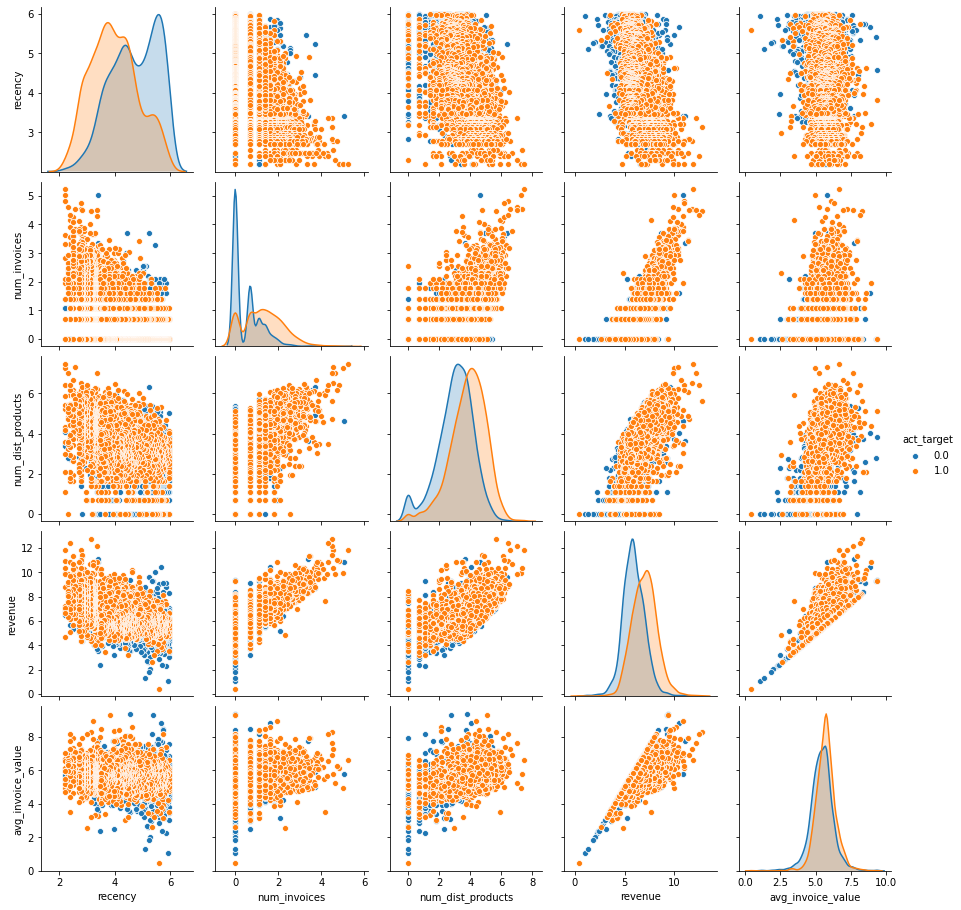

In [ ]:
sns.pairplot(data=flatfile.iloc[:, 1:], hue='act_target');

## Modelltraining Aktivitätsmodell

In [ ]:
# Teile Daten in Prädiktoren und Zielvariable, anschließend in Trainings- und Testdatensätze 

from sklearn.model_selection import train_test_split

X = flatfile.drop(['customerid', 'act_target'], axis=1)
y = flatfile['act_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Modelltraining mit Logistischer Regression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()

print('Training without standardization')
lr_model.fit(X_train, y_act_train)

Training without standardization


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Modellvalidierung Aktivitätsmodell

In [ ]:
# Überprüfe Modellqualität auf Testdaten
from sklearn.metrics import accuracy_score, plot_confusion_matrix

# Klassifizierung
y_act_predict = lr_model.predict(X_test)

# Ausgabe der zugrunde liegenden Wahrscheinlichkeiten
y_act_probas = lr_model.predict_proba(X_test)

Accuracy Score:
0.7247451343836886

Confusion Matrix:


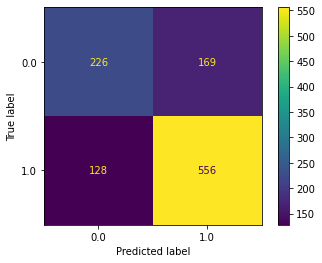

In [ ]:
print('Accuracy Score:')
print(accuracy_score(y_act_test, y_act_predict))
print('')
print('Confusion Matrix:')
plot_confusion_matrix(lr_model, X_test, y_act_test, values_format='d');

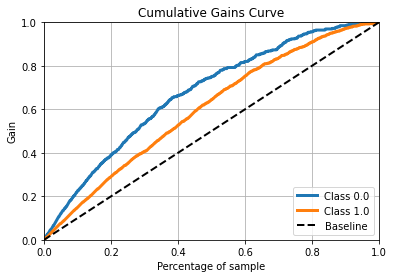

In [ ]:
from scikitplot.metrics import plot_cumulative_gain

plot_cumulative_gain(y_test, y_act_probas);

In [184]:
# Modellverständnis

pd.DataFrame(data=lr_model.coef_.T, index=X_train.columns, columns=['Koeffizient'])

,Koeffizient
recency,-0.558708
num_invoices,0.526562
num_dist_products,0.019963
revenue,0.432582
avg_invoice_value,-0.093980


## Modell speichern

In [ ]:
import pickle

with open('drive/My Drive/Colab Models/clf_model.pickle', 'wb') as f:
    pickle.dump(lr_model, f)